The very bottom panel has the equations from temporary polynomial fits. With too high a degree, you can filter out based on relative importance (single zernike coefficients 10x less than no zernikes, double zernikes 100x, etc) and you get things that have at least the right players, and somewhat the same forms modulo the occasional terms oddly out of proportion

In [1]:
%matplotlib inline

In [171]:
# load up relevant packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso, LassoLars, Ridge, LinearRegression


# this part taken from https://github.com/mrocklin/multipolyfit/blob/master/multipolyfit/core.py
from numpy import linalg, zeros, ones, hstack, asarray
from itertools import combinations_with_replacement

def basis_vector(n, i):
    """ Return an array like [0, 0, ..., 1, ..., 0, 0]
    >>> from multipolyfit.core import basis_vector
    >>> basis_vector(3, 1)
    array([0, 1, 0])
    >>> basis_vector(5, 4)
    array([0, 0, 0, 0, 1])
    """
    x = zeros(n, dtype=int)
    x[i] = 1
    return x

def as_tall(x):
    """ Turns a row vector into a column vector """
    return x.reshape(x.shape + (1,))

def stack_x(xs, deg):

    num_covariates = xs.shape[1]
    xs = hstack((ones((xs.shape[0], 1), dtype=xs.dtype) , xs))

    generators = [basis_vector(num_covariates+1, i)
                  for i in range(num_covariates+1)]

    # All combinations of degrees
    powers = map(sum, combinations_with_replacement(generators, deg))

    # Raise data to specified degree pattern, stack in order
    A = hstack(asarray([as_tall((xs**p).prod(1)) for p in powers]))

    return A, powers

def power_selector(zi, zj, powers, beta):
    powersum = np.sum(powers[0])
    powers_desired = np.zeros(len(powers[0]), dtype=np.int)
    powers_desired[zi - 3] += 1
    powers_desired[zj - 3] += 1
    powers_desired[0] = powersum - np.sum(powers_desired)
    ith = np.array([np.all(power == powers_desired) for power in powers])
    return beta[ith]

def mk_pretty_function(beta, powers, x_keys=['', 'r0'] + ['z{0}'.format(i) for i in xrange(4, 12)],
                       min_threshold=-20):
    num_covariates = len(powers[0]) - 1
    xs = [''] + x_keys
    terms = []
    for ith in xrange(len(beta)):
        coef = beta[ith]
        # since z is in the range -1 to 1, you can imagine that 
        # each additional zernike requires a compensation in the
        # coefficient by another order of magnitude
        if 'x' in x_keys:
            if_coord = powers[ith][xs.index('x')] * 2
            if_coord += powers[ith][xs.index('y')] * 2
        else:
            if_coord = 0
        if np.abs(coef) < 10 ** (min_threshold - powers[ith][0] + if_coord + np.sum(powers[ith])):
            coef = 0
        power = powers[ith]
        term = '{0:.2e}'.format(coef)
        if term.count('0') == 5:
            continue
        term += ' '
        for power_ith in xrange(len(power)):
            term_power = xs[power_ith]
            number_terms = power[power_ith]
            for j in xrange(number_terms):
                term += term_power
        if len(term) > 0:
            terms.append(term)
    # print the terms
    string = ''
    for term in terms:
        string += term
        string += ' + '
    return terms, string


In [3]:
# load up the coeffs for lasso and linear
donut_dir = '/Users/cpd/Projects/WavefrontPSF/meshes'

df = pd.read_csv(donut_dir + '/interpolated_zernikes.csv', index_col=0)

x_keys = ['rzero']

for zi in xrange(4, 12):
    zkey = 'z{0}'.format(zi)
    x_keys.append(zkey)

y_keys = ['flux', 'Mx', 'My', 'e0prime', 'e0', 'e1', 'e2',
          'delta1', 'delta2', 'zeta1', 'zeta2']
# fudge
df['e0prime'] = df['e0']
# stack xs
deg = 4  # want 2d polynomial
xs = df[x_keys].values
ys = df[y_keys].values
x_powers, powers = stack_x(xs, deg)


In [4]:
linear = LinearRegression(fit_intercept=False, normalize=False)
linear.coef_ = np.load(donut_dir + '/coeffs_linear.npy')
linear.intercept_ = 0
linear_predict = linear.predict(x_powers)
lasso = Lasso(alpha=1e-3, normalize=False, fit_intercept=False, tol=1e-8)
lasso.fit(x_powers[:10], ys[:10])
lasso.coef_ = np.load(donut_dir + '/coeffs_lasso.npy')
lasso.intercept_ = 0
lasso_predict = lasso.predict(x_powers)


regressor = lasso
predict = lasso_predict

In [5]:
# add these to the df
for y_key_i, y_key in enumerate(y_keys):
    df['linear_{0}'.format(y_key)] = linear_predict[:, y_key_i]
    df['diff_linear_{0}'.format(y_key)] = (linear_predict[:, y_key_i] - df[y_key])
    df['lasso_{0}'.format(y_key)] = lasso_predict[:, y_key_i]
    df['diff_lasso_{0}'.format(y_key)] = (lasso_predict[:, y_key_i] - df[y_key])

In [6]:
from IPython.html.widgets import interact

def func(const_txt='1.', y_key='e0', regression='lasso'):
    if regression == 'lasso':
        regressor = lasso
    elif regression == 'linear':
        regressor = linear
        
    yith = y_keys.index(y_key)

    const = float(const_txt)
    beta = (const * regressor.coef_)[yith]

    terms, string = mk_pretty_function(beta, powers)

    print(y_key + ' = ' + string)
interact(func, y_key=y_keys, regression=['lasso', 'linear'])

e0 = 7.37e-01  + -2.84e+00 r0 + 6.06e-02 z4z4 + 1.31e-02 z4z11 + 3.95e-02 z5z5 + 3.80e-02 z6z6 + 7.61e-02 z7z7 + 7.05e-02 z8z8 + 8.42e-02 z9z9 + 8.39e-02 z10z10 + 1.21e-01 z11z11 + -1.95e-02 z5z7z8z11 + 


<function __main__.func>

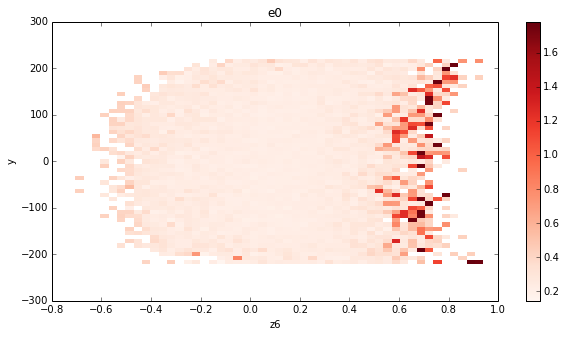

In [7]:
from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(xkey='z4', ykey='rzero', zkey='e0'):
        
    # plot predictions
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey, num_bins=50)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey)
interact(func)

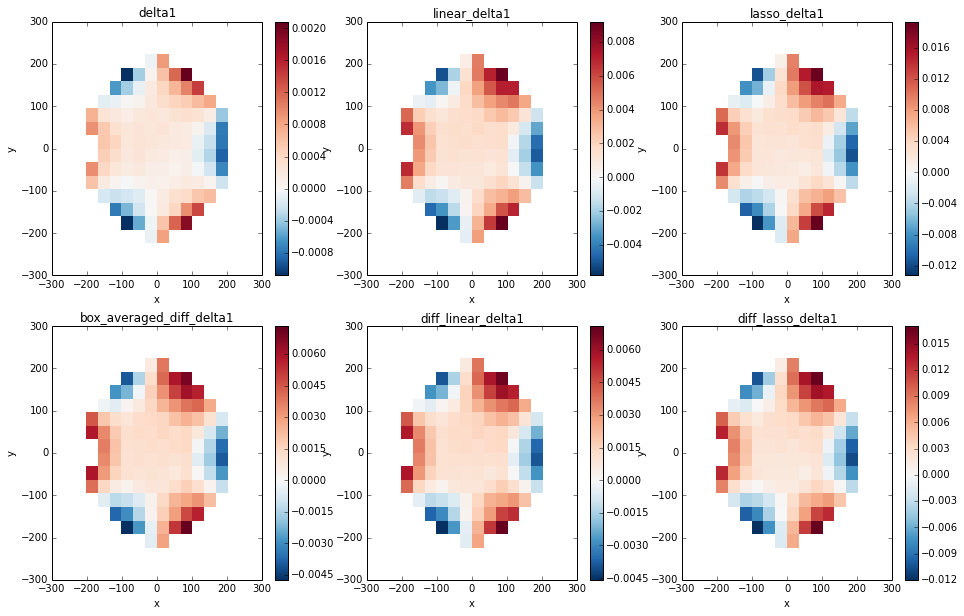

In [183]:
from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(zkey='e0', num_bins=3):
        
    field, bins_x, bins_y = WF.reduce_data_to_field(
                df, xkey='x', ykey='y', num_bins=num_bins)
    xkey = 'x'
    ykey = 'y'
    # plot predictions
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,10))
    ax = axs[0,0]
    fig, ax = WF.plot_field(zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey)

    ax = axs[0,1]
    fig, ax = WF.plot_field('linear_' + zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('linear_' + zkey)
    
    ax = axs[0,2]
    fig, ax = WF.plot_field('lasso_' + zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('lasso_' + zkey)
    
    ax = axs[1,0]
    field['box_averaged_diff'] = field['linear_' + zkey] - field[zkey]
    fig, ax = WF.plot_field('box_averaged_diff', field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('box_averaged_diff_' + zkey)    
    
    ax = axs[1,1]
    fig, ax = WF.plot_field('diff_linear_' + zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('diff_linear_' + zkey)
    
    ax = axs[1,2]
    fig, ax = WF.plot_field('diff_lasso_' + zkey, field, bins_x=bins_x, bins_y=bins_y, fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title('diff_lasso_' + zkey)
interact(func, num_bins=(0,4))

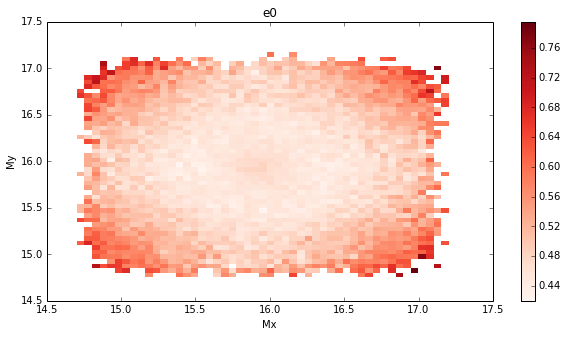

In [11]:
from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(rzero, varcoords=True, num_bins_txt='25', xkey='z4', ykey='z5', zkey='e0'):
    df = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, {True: 'var', False: 'const'}[varcoords]),
                     index_col=0)
    # plot predictions
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey, num_bins=int(num_bins_txt))
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey)
interact(func, rzero=(0,5))

<function __main__.func>

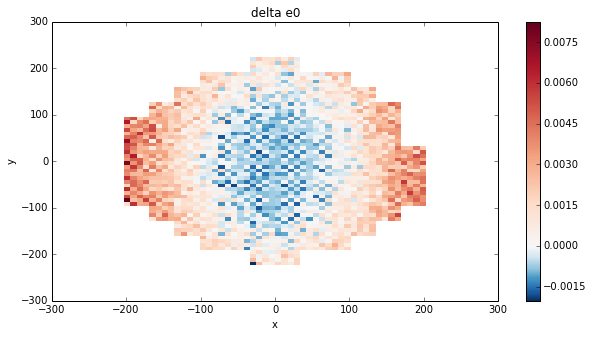

In [42]:
# effects on moments of incorporating focal plane coordinates

from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(rzero, abs=False, num_bins_txt='3', zkey='e0'):
    xkey='x'
    ykey='y'
    df1 = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, 'var'),
                     index_col=0)
    df2 = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, 'const'),
                     index_col=0)
    df1[y_keys] = df1[y_keys] - df2[y_keys]
    if abs:
        for key in y_keys:
            df1[key] = np.abs(df1[key])
    df = df1
    # plot predictions
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey, num_bins=int(num_bins_txt))
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    if abs:
        ax.set_title('abs(delta ' + zkey + ')')
    else:
        ax.set_title('delta ' + zkey)
interact(func, rzero=(0,5))

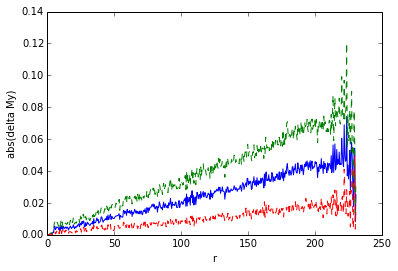

In [41]:
# effects on moments of incorporating focal plane coordinates
def mad(x):
    return np.median(np.abs(x - np.median(x)))
def func(rzero, abs=False, num_bins_txt='100', zkey='e0', xoffset_txt='10'):
    df1 = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, 'var'),
                     index_col=0)
    df2 = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
            rzero, 'const'),
                     index_col=0)
    xoffset = np.float(xoffset_txt)
    df1[y_keys] = df1[y_keys] - df2[y_keys]
    if abs:
        for key in y_keys:
            df1[key] = np.abs(df1[key])
    df1['r'] = np.sqrt((df1['x'] - xoffset) ** 2 + (df1['y']) ** 2)
    bins_r = np.linspace(df1['r'].min(), df1['r'].max(), int(num_bins_txt))
    groups = df1.groupby(pd.cut(df1['r'], bins_r))
    centers_r = 0.5 * (bins_r[1:] + bins_r[:-1])
    agg = groups.aggregate(np.median)
    agg_mad = groups.aggregate(mad)

    # plot predictions
    fig, ax = plt.subplots()
    ax.set_xlabel('r')

    if abs:
        ax.set_ylabel('abs(delta ' + zkey + ')')
    else:
        ax.set_ylabel('delta ' + zkey)

    ax.plot(centers_r, agg[zkey])
    ax.plot(centers_r, agg[zkey] + agg_mad[zkey], '--')
    ax.plot(centers_r, agg[zkey] - agg_mad[zkey], '--')

interact(func, rzero=(0,5), xoffset_txt=['-10', '0', '10', '-100'])

In [46]:
x_keys_train = ['x', 'y', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11']

In [140]:
# do super basic regression training here and then use these for the inputs below
model = {}
x_keys_train = ['x', 'y', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11']
for varcoords in [True, False]:
    if varcoords:
        x_keys_train_use = x_keys_train
    else:
        x_keys_train_use = x_keys_train[2:]
    for rzero in xrange(6):
        dfi = pd.read_csv(donut_dir + '/indivi/donuts_{0}_{1}coords.csv'.format(
                rzero, {True: 'var', False: 'const'}[varcoords]),
                         index_col=0)
        deg = 4  # want 2d polynomial
        xs = dfi[x_keys_train_use].values  # no rzero
        ys = dfi[y_keys].values
        xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.3)
        x_powers_train, powers = stack_x(xs_train, deg)
        x_powers_test, powers = stack_x(xs_test, deg)


        print('training linear', varcoords, rzero)
        regressor = LinearRegression(fit_intercept=False, normalize=False)
        regressor.fit(x_powers_train, ys_train)
        ys_pred = regressor.predict(x_powers_test)
        model[(varcoords, rzero)] = [xs_test, ys_test, ys_pred, regressor.coef_.copy(), powers]

training linear True 0
training linear True 1
training linear True 2
training linear True 3
training linear True 4
training linear True 5
training linear False 0
training linear False 1
training linear False 2
training linear False 3
training linear False 4
training linear False 5


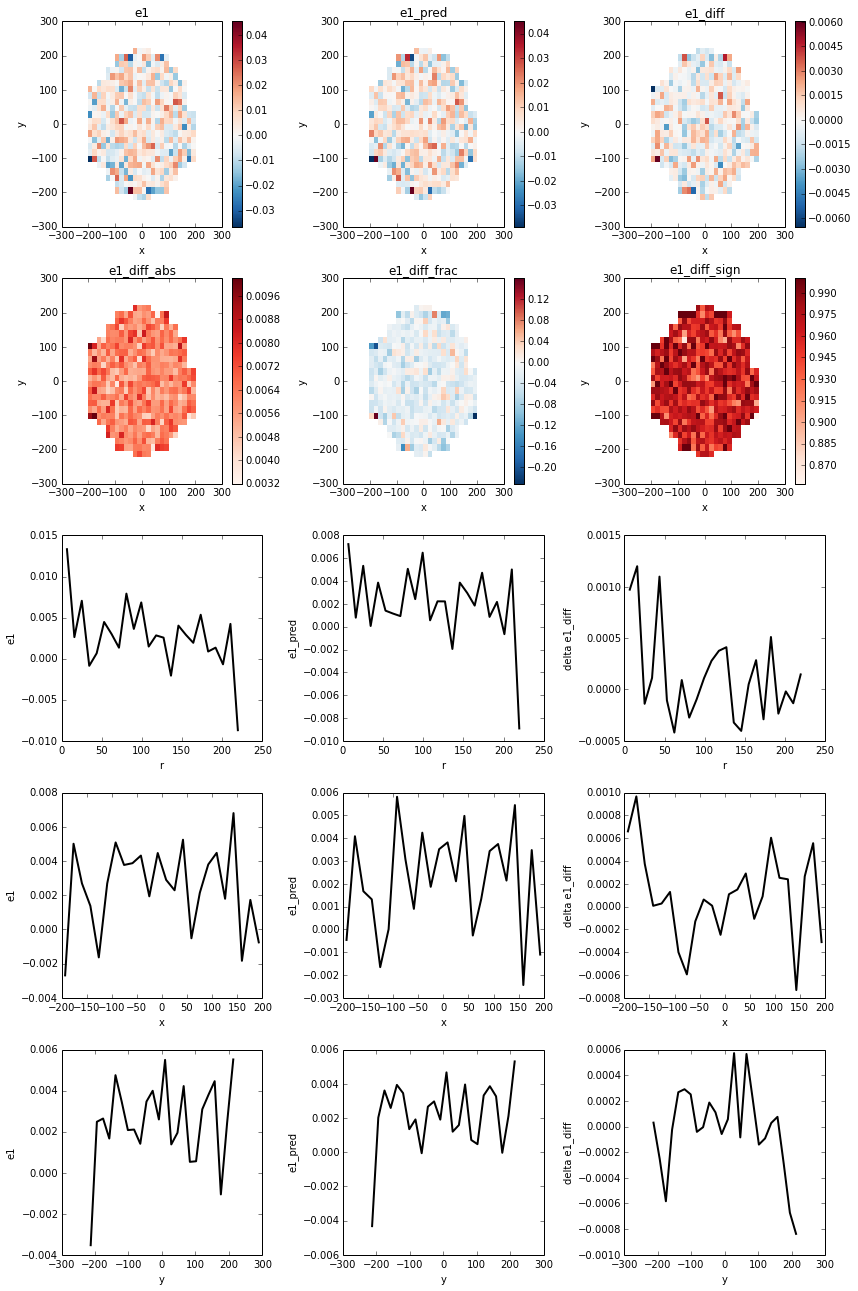

In [204]:

from WavefrontPSF.wavefront import Wavefront
from WavefrontPSF.psf_evaluator import Moment_Evaluator
WF = Wavefront(None, None, Moment_Evaluator())
def func(rzero, varcoords=False, abs=True, num_bins_txt='25', xkey='z4', ykey='z5', zkey='e2'):

    if varcoords:
        x_keys_train_use = x_keys_train
    else:
        x_keys_train_use = x_keys_train[2:]
    xs_test, ys_test, ys_pred, coef, powers = model[(varcoords, rzero)]
    if abs:
        ys_test = np.abs(ys_test)
        ys_pred = np.abs(ys_pred)
    df = {xkey: xs_test[:, x_keys_train_use.index(xkey)],
          ykey: xs_test[:, x_keys_train_use.index(ykey)],
          zkey: ys_test[:, y_keys.index(zkey)],
          zkey + '_pred': ys_pred[:, y_keys.index(zkey)],
          zkey + '_diff': -ys_test[:, y_keys.index(zkey)] + ys_pred[:, y_keys.index(zkey)],
          zkey + '_diff_sign': 0.5 * (np.sign(ys_test[:, y_keys.index(zkey)] * ys_pred[:, y_keys.index(zkey)]) + 1),
          zkey + '_diff_abs': np.abs(-ys_test[:, y_keys.index(zkey)] + ys_pred[:, y_keys.index(zkey)]),
          zkey + '_diff_frac': (-ys_test[:, y_keys.index(zkey)] + ys_pred[:, y_keys.index(zkey)]) / ys_test[:, y_keys.index(zkey)]}
    df = pd.DataFrame(df)
    # plot predictions
    fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(12,18))
    ax = axs[0,0]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey, num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey)
    
    # plot predictions
    ax = axs[0,1]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_pred', num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_pred')
    
    # plot difference
    ax = axs[0,2]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_diff', num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_diff')
    
    # plot fractional difference
    ax = axs[1,1]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_diff_frac', num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_diff_frac')
    
    # plot difference
    ax = axs[1,0]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_diff_abs', num_bins=int(num_bins_txt), fig=fig, ax=ax)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_diff_abs')
    
    # plot the sign difference
    # value in pixel = fraction of values whose signs agreed between prediction and truth
    ax = axs[1,2]
    fig, ax = WF.plot_colormap(df, xkey, ykey, zkey + '_diff_sign', num_bins=int(num_bins_txt), fig=fig, ax=ax,
                               reducer=np.mean)
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)
    ax.set_title(zkey + '_diff_sign')
    
    # do as radial function from center of xkey and ykey
    df['r'] = np.sqrt((df[xkey]) ** 2 + (df[ykey]) ** 2)
    bins_r = np.linspace(df['r'].min(), df['r'].max(), int(num_bins_txt))
    groups = df.groupby(pd.cut(df['r'], bins_r))
    centers_r = 0.5 * (bins_r[1:] + bins_r[:-1])
    agg = groups.aggregate(np.median)
    
    ax = axs[2, 0]
    ax.set_xlabel('r')
    if abs:
        ax.set_ylabel('abs(' + zkey + ')')
    else:
        ax.set_ylabel('' + zkey)
    ax.plot(centers_r, agg[zkey], 'k-', linewidth=2)
    ax = axs[2, 1]
    ax.set_xlabel('r')
    if abs:
        ax.set_ylabel('abs(' + zkey  + '_pred'+ ')')
    else:
        ax.set_ylabel('' + zkey + '_pred')
    ax.plot(centers_r, agg[zkey + '_pred'], 'k-', linewidth=2)
    ax = axs[2, 2]
    ax.set_xlabel('r')
    if abs:
        ax.set_ylabel('abs(delta ' + zkey  + '_diff'+ ')')
        ax.plot(centers_r, agg[zkey + '_diff_abs'], 'k-', linewidth=2)
    else:
        ax.set_ylabel('delta ' + zkey + '_diff')
        ax.plot(centers_r, agg[zkey + '_diff'], 'k-', linewidth=2)
    
    # do as function of each individual axis, too
    bins_r = np.linspace(df[xkey].min(), df[xkey].max(), int(num_bins_txt))
    groups = df.groupby(pd.cut(df[xkey], bins_r))
    centers_r = 0.5 * (bins_r[1:] + bins_r[:-1])
    agg = groups.aggregate(np.median)
    
    ax = axs[3,0]
    ax.set_xlabel(xkey)
    if abs:
        ax.set_ylabel('abs(' + zkey + ')')
    else:
        ax.set_ylabel('' + zkey)
    ax.plot(centers_r, agg[zkey], 'k-', linewidth=2)
    
    ax = axs[3,1]
    ax.set_xlabel(xkey)
    if abs:
        ax.set_ylabel('abs(' + zkey + '_pred' + ')')
    else:
        ax.set_ylabel('' + zkey + '_pred')
    ax.plot(centers_r, agg[zkey + '_pred'], 'k-', linewidth=2)
    
    ax = axs[3,2]
    ax.set_xlabel(xkey)
    if abs:
        ax.set_ylabel('abs(delta ' + zkey + '_diff' + ')')
        ax.plot(centers_r, agg[zkey + '_diff_abs'], 'k-', linewidth=2)
    else:
        ax.set_ylabel('delta ' + zkey + '_diff')
        ax.plot(centers_r, agg[zkey + '_diff'], 'k-', linewidth=2)
    
    bins_r = np.linspace(df[ykey].min(), df[ykey].max(), int(num_bins_txt))
    groups = df.groupby(pd.cut(df[ykey], bins_r))
    centers_r = 0.5 * (bins_r[1:] + bins_r[:-1])
    agg = groups.aggregate(np.median)
    
    ax = axs[4,0]
    ax.set_xlabel(ykey)
    if abs:
        ax.set_ylabel('abs(' + zkey + ')')
    else:
        ax.set_ylabel('' + zkey)
    ax.plot(centers_r, agg[zkey], 'k-', linewidth=2)
    
    ax = axs[4,1]
    ax.set_xlabel(ykey)
    if abs:
        ax.set_ylabel('abs(' + zkey + '_pred' + ')')
    else:
        ax.set_ylabel('' + zkey + '_pred')
    ax.plot(centers_r, agg[zkey + '_pred'], 'k-', linewidth=2)

    ax = axs[4,2]
    ax.set_xlabel(ykey)
    if abs:
        ax.set_ylabel('abs(delta ' + zkey + '_diff' + ')')
        ax.plot(centers_r, agg[zkey + '_diff_abs'], 'k-', linewidth=2)
    else:
        ax.set_ylabel('delta ' + zkey + '_diff')
        ax.plot(centers_r, agg[zkey + '_diff'], 'k-', linewidth=2)
    plt.tight_layout()
    
    return df
interact(func, rzero=(0,5), xkey=x_keys_train, ykey=x_keys_train, zkey=y_keys)

In [180]:
# look at effects on coordinates
def func(rzero1, drzero2, y_key='e0', varcoords=False, min_threshold=-4, const_txt='1'):
    
    rzero2 = rzero1 + drzero2
    yith = y_keys.index(y_key)

    if varcoords:
        x_keys_train_use = x_keys_train
    else:
        x_keys_train_use = x_keys_train[2:]
    _, _, _, coef1, powers = model[(varcoords, rzero1)]
    if rzero1 == rzero2:
        coef = coef1
    else:
        _, _, _, coef2, powers = model[(varcoords, rzero2)]
        coef = (coef1 - coef2)
    const = float(const_txt)
    coef = coef * const
    terms, string = mk_pretty_function(coef[yith], powers, x_keys=x_keys_train_use,
                                       min_threshold=min_threshold)
    print('{0} = {1}'.format(y_key, string))
    
interact(func, rzero1=(0,5), drzero2=(-3,3), y_key=y_keys, min_threshold=(-10,4))

e0 = 6.37e+01  + -2.37e-01 z5 + -1.30e-01 z7 + 1.39e-01 z10 + 1.99e+01 z4z4 + 2.29e+01 z4z11 + 1.15e+01 z5z5 + 1.15e+01 z6z6 + 2.32e+01 z7z7 + -1.06e+00 z7z9 + 2.18e+01 z8z8 + 2.16e+01 z9z9 + 2.22e+01 z10z10 + 4.53e+01 z11z11 + 
